In [1]:
import w1d4_tests
import matplotlib.pyplot as plt

import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import einops

# Reproduce a gorilla

In [2]:
%%capture
!wget -O gorilla.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Gorille_des_plaines_de_l%27ouest_%C3%A0_l%27Espace_Zoologique.jpg/1200px-Gorille_des_plaines_de_l%27ouest_%C3%A0_l%27Espace_Zoologique.jpg

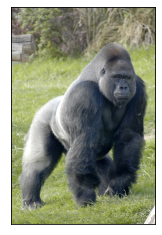

In [3]:
w1d4_tests.plot_image("gorilla.jpg")

In [4]:
data_train, data_test =  w1d4_tests.load_image("gorilla.jpg")

class MyNet(nn.Module):
    def __init__(self, P: int, H: int, K: int):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features=P, out_features=H),
            nn.ReLU(),
            nn.Linear(in_features=H, out_features=H),
            nn.ReLU(),
            nn.Linear(in_features=H, out_features=K),
        )

    def forward(self, x):
        return self.net(x)
        
w1d4_tests.test_mlp(MyNet)

Congrats! You've passed the test.


In [5]:
def train(
    model: nn.Module, dataloader: DataLoader, lr: float, momentum: float,
) -> nn.Module:
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = F.l1_loss

    for input, target in dataloader:
        optimizer.zero_grad()

        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

    return model


w1d4_tests.test_train(train)


Congrats! You've passed the test.


In [6]:
def evaluate(model: nn.Module, dataloader: DataLoader) -> t.Tensor:
    loss_fn = F.l1_loss

    total_loss = t.tensor(0.0)
    num_datapoints: int = 0
    for input, target in dataloader:

        output = model(input)
        loss = loss_fn(output, target)

        cur_datapoints = len(target)

        total_loss += loss * cur_datapoints
        num_datapoints += cur_datapoints

    return total_loss / num_datapoints

w1d4_tests.test_evaluate(evaluate)

Congrats! You've passed the test.


In [7]:
for inp, target in data_train:
    print(inp.shape)
    print(target.shape)
    break

torch.Size([128, 2])
torch.Size([128, 3])


In [8]:
model = MyNet(P=2, H=400, K=3)

train_losses = []
test_losses = []
for epoch in range(500):
    model = train(model, data_train, lr=5*1e-3, momentum=0.9)

    train_loss = float(evaluate(model, data_train))
    test_loss = float(evaluate(model, data_test))

    if epoch % 10 == 0:
        print(f"{epoch=}; train={train_loss}; test={test_loss}")

    train_losses.append(train_loss)
    test_losses.append(test_loss)

epoch=0; train=0.16158677637577057; test=0.16269315779209137
epoch=10; train=0.12842127680778503; test=0.1278994083404541
epoch=20; train=0.11373452097177505; test=0.11393363773822784
epoch=30; train=0.10818345099687576; test=0.10920767486095428
epoch=40; train=0.10952357947826385; test=0.10976279526948929
epoch=50; train=0.10420186817646027; test=0.10484161972999573
epoch=60; train=0.104367695748806; test=0.10499978810548782
epoch=70; train=0.10699351131916046; test=0.10772857815027237
epoch=80; train=0.10106047987937927; test=0.10125697404146194
epoch=90; train=0.09881452471017838; test=0.09929145872592926
epoch=100; train=0.0979960560798645; test=0.09819114208221436
epoch=110; train=0.09748094528913498; test=0.09774837642908096
epoch=120; train=0.09768395870923996; test=0.0977596566081047
epoch=130; train=0.0974678173661232; test=0.09732168912887573
epoch=140; train=0.09741343557834625; test=0.09696675837039948
epoch=150; train=0.09860357642173767; test=0.09758908301591873
epoch=160

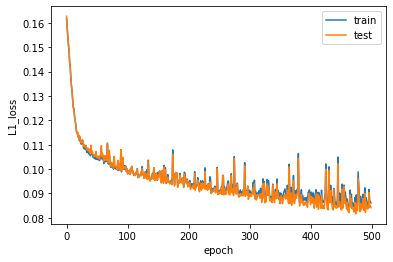

In [9]:
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("epoch"); plt.ylabel("L1_loss");
plt.legend();

(64, 64, 3)


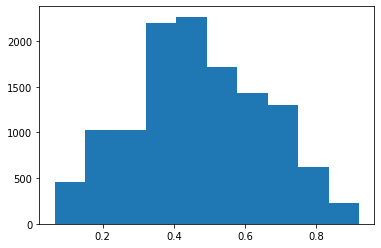

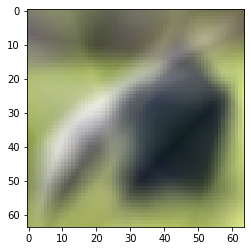

In [11]:
def get_image_from_fn(
    model,
    H: int = 200,
    W: int = 200,
    xstart=-0.5,
    xend=0.5,
    ystart=-0.5,
    yend=0.5,
) -> t.Tensor:
    hs = t.linspace(start=ystart, end=yend, steps=H)
    ws = t.linspace(start=xstart, end=xend, steps=W)

    expanded_hs = einops.repeat(hs, "h -> h w", w=W)
    expanded_ws = einops.repeat(ws, "w -> h w", h=H)

    coords = t.stack((expanded_hs, expanded_ws), dim=-1)

    return model(coords) + 0.5


with t.no_grad():
    img = get_image_from_fn(model, H=64, W=64).numpy()

print(img.shape)
plt.hist(img.flatten())
plt.show()
plt.imshow(img)

# Rosenbrock banana

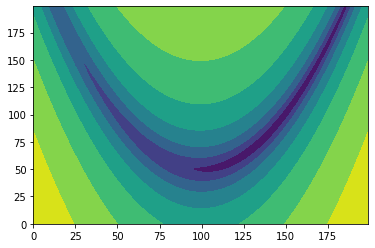

In [12]:
def f(x, y, a=1, b=100):
    return (a - x) ** 2 + b * (y - x ** 2) ** 2 + 1


image = get_image_from_fn(
    lambda xy: f(xy[..., 1], xy[..., 0]),
    xstart=-2,
    xend=2,
    ystart=-1,
    yend=3,
)

plt.contourf(t.log(image))